# Taxi Travel Data Exploratory Analysis

In this demo, we will be doing some demos on temporal feature engineering with the Kaggle Dataset

### Loading libraries, datasets

In [8]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

In [9]:
# These are all of the files you are given
df_tr = pd.read_csv("train_data.csv")

In [10]:
df_tr.head()

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TIMESTAMP,NEW_TIMESTAMP,DAY_TYPE,POLYLINE,TRIP_TIME
0,C,NaN,NaN,1372636858,0,A,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",345
1,B,NaN,7.0,1372637303,0,A,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",285
2,C,NaN,NaN,1372636951,0,A,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",975
3,C,NaN,NaN,1372636854,0,A,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",645
4,C,NaN,NaN,1372637091,0,A,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",435


### Get Computed Time from POLYLINE

Our goal is to predict the travel-time of the taxi, which can be derived from the POLYLINE length.

Recall:

```
The travel time of the trip (the prediction target of this project) is defined as the (number of points-1) x 15 seconds. 
For example, a trip with 101 data points in POLYLINE has a length of (101-1) * 15 = 1500 seconds. Some trips have missing 
data points in POLYLINE, indicated by MISSING_DATA column, and it is part of the challenge how you utilize this knowledge.
```

We are not doing anything with the MISSING_DATA. It is up to you to find a way to use (or ignore) that information.

In [11]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [12]:
from datetime import datetime
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

### Create a Prediction File

In [13]:
mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
median = df_tr["LEN"].median()
print(f"{mean=} {median=} {std=}")

mean=716.4222405387394 median=600.0 std=684.7289510994718


In [14]:
# Sample submission file that is given on kaggle
df_sample = pd.read_csv("sampleSubmission.csv")

df_sample["TRAVEL_TIME"] = 716.43

# mean(716.43) -> 792.73593
# median(600) -> 784.74219
df_sample.to_csv("my_pred.csv", index=None)

### Do some Feature Analysis

For our feature analysis, we are looking at which of our engineered features may be useful in making a taxicab time regression model

Using: 1692763/1710660


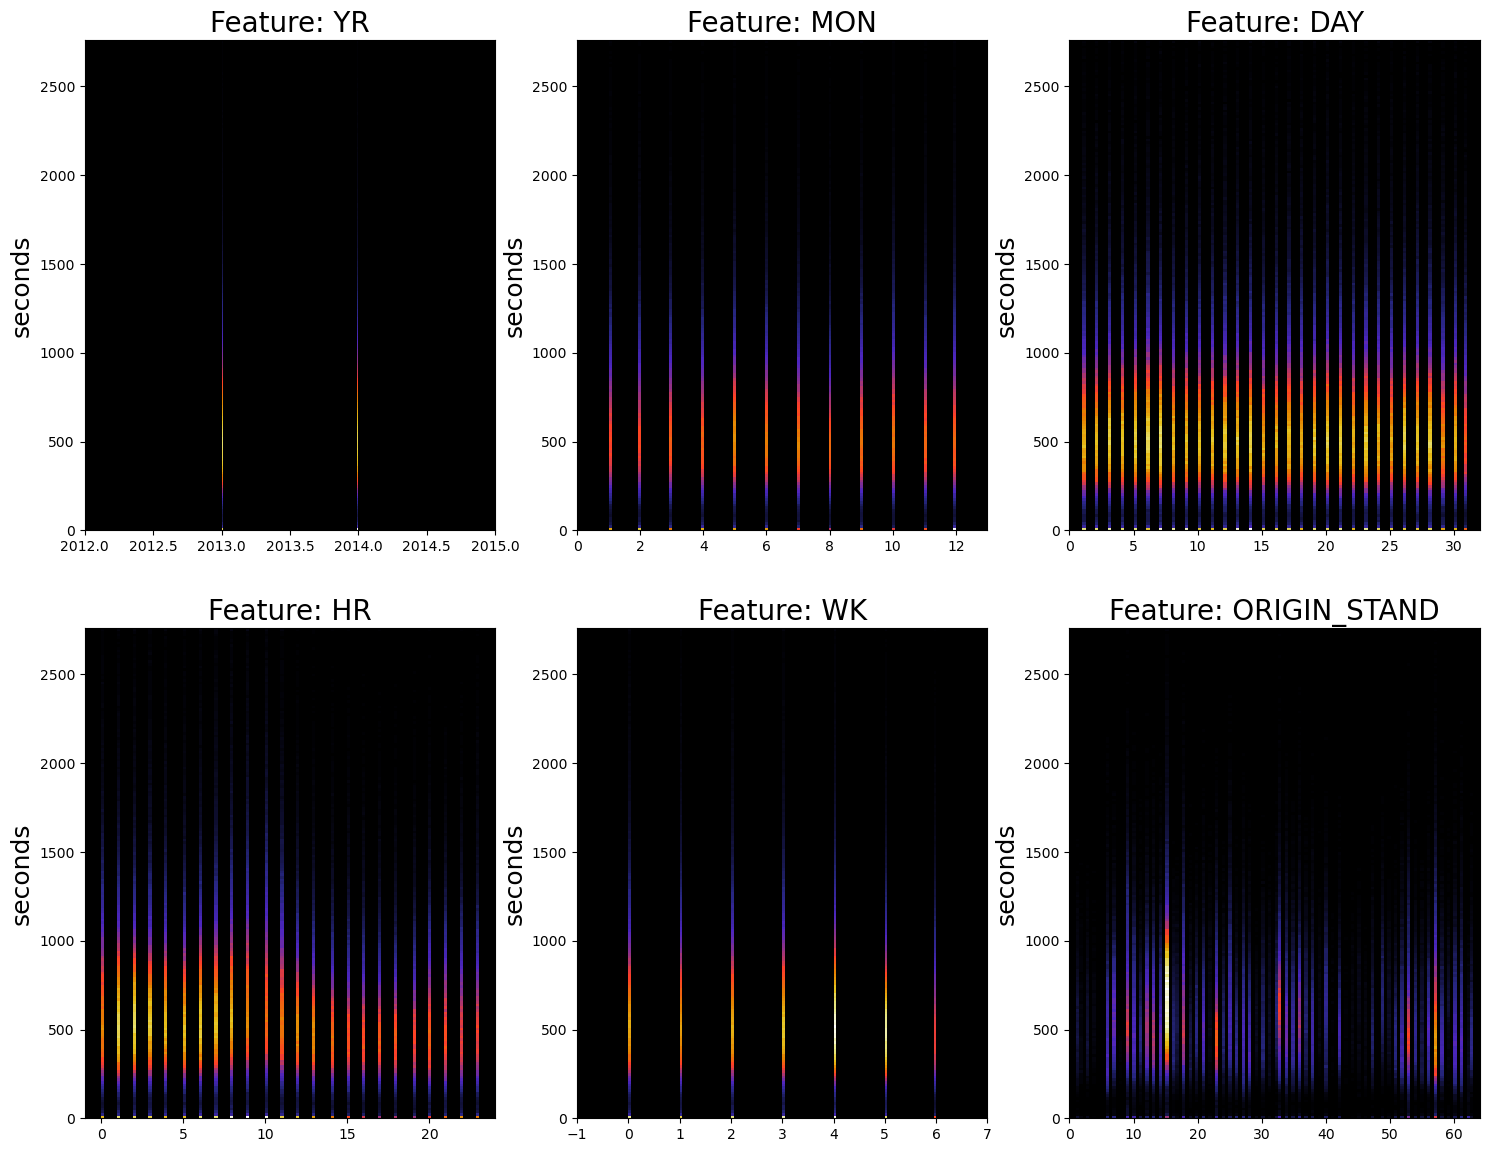

In [15]:
# First n samples to analyze. Set to -1 to use all data
end = -1

outlier_threshold = 3

# "Choose all data, where the trip length is less than 3 standard deviations away from the mean"
# This is to remove outliers. Otherwise, our plots would look very squished (since there are some
# VERRRRRY long taxi trips in the dataset)
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]

# Because our y-values only take on multiples of 15, we want just enough buckets in a histogram
# such that each buckets counts one value's frequency. (e.x. one bucket counts how many 15s trips, 
# how many 30s trips, etc. )
buckets = (int(mean + outlier_threshold * std) // 15)

print(f"Using: {len(df_trimmed)}/{len(df_tr)}")

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,14))

# Now, we visualize some features that we think might be useful
for idx, v in enumerate(["YR", "MON", "DAY", "HR", "WK", "ORIGIN_STAND"]):
  # idx // 3 = row, idx % 3 = column
  ax = axs[idx // 3, idx % 3]
  
  # Remove any rows with invalid values
  df_subset = df_trimmed.dropna(subset=v)
  
  # Create a histogram. Look up the documentation for more details
  ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))
  
  # Some stylistic things to make the graphs look nice
  ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
  ax.set_facecolor("black")
  ax.set_ylabel("seconds", fontsize=18)
  ax.set_title(f"Feature: {v}", fontsize=20)


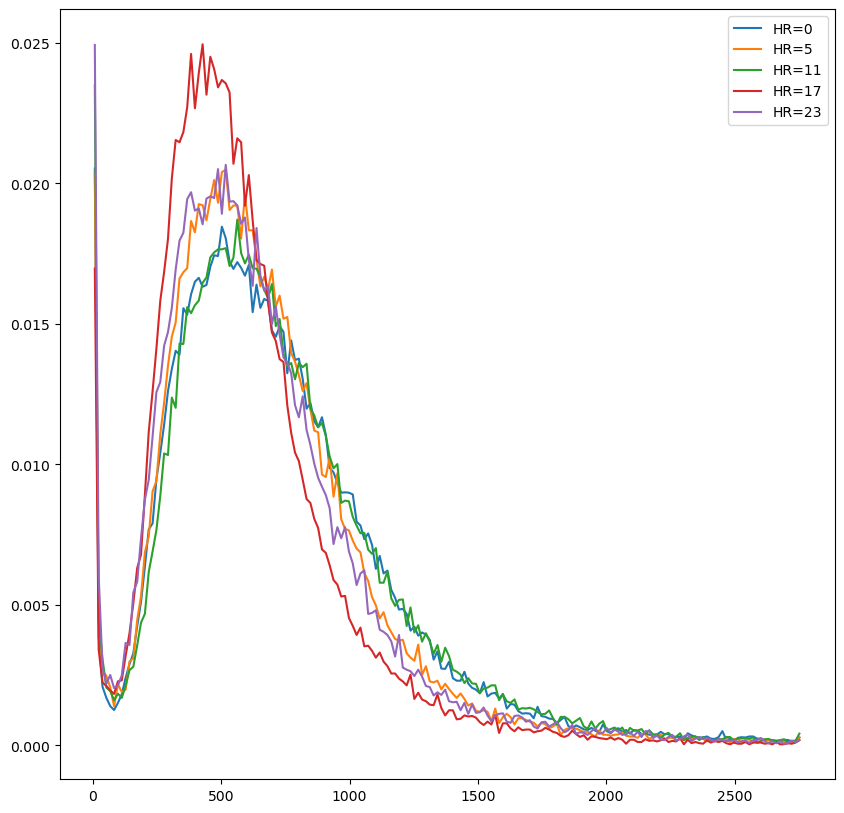

In [16]:
plt.figure(figsize=(10,10))
for v in [0, 5, 11, 17, 23]:
  # Filter data where the HR matches v
  hourly_data = df_trimmed[df_trimmed["HR"] == v]["LEN"]
  histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
  histogram = histogram / len(hourly_data)
  # The center is the left_bound and right_bound of a bucket
  bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
  plt.plot(bin_centers, histogram, label=f"HR={v}")
plt.legend();

## Data Visualization

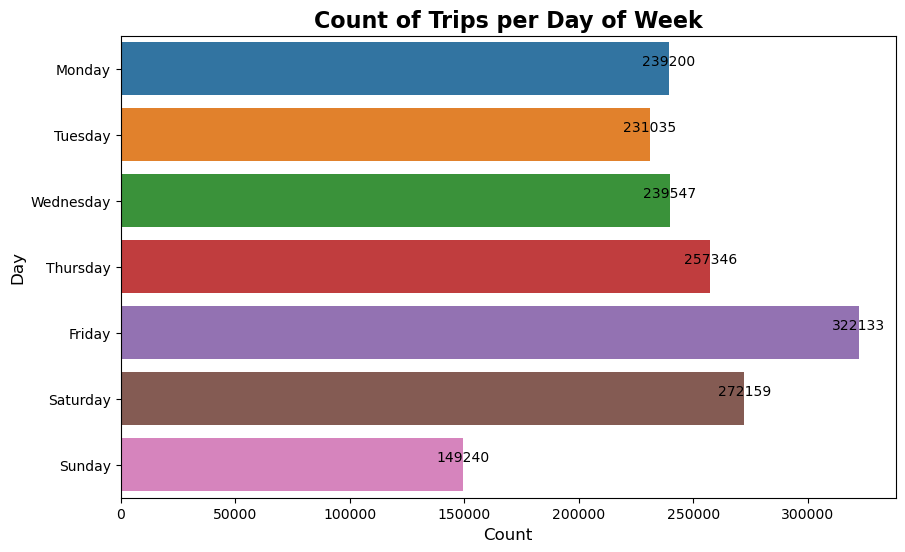

In [18]:
import seaborn as sns

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the count of trips per day of week
ax = sns.countplot(y='WK', data=df_tr)

# Set the title
plt.title('Count of Trips per Day of Week', fontsize=16, fontweight='bold')

# Set the x and y labels
plt.xlabel('Count', fontsize=12)
plt.ylabel('Day', fontsize=12)

# Customize the tick labels
ax.set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=10)

# Add value labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), (p.get_width() + 10, p.get_y() + p.get_height() / 2),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)

# Show the plot
plt.show()


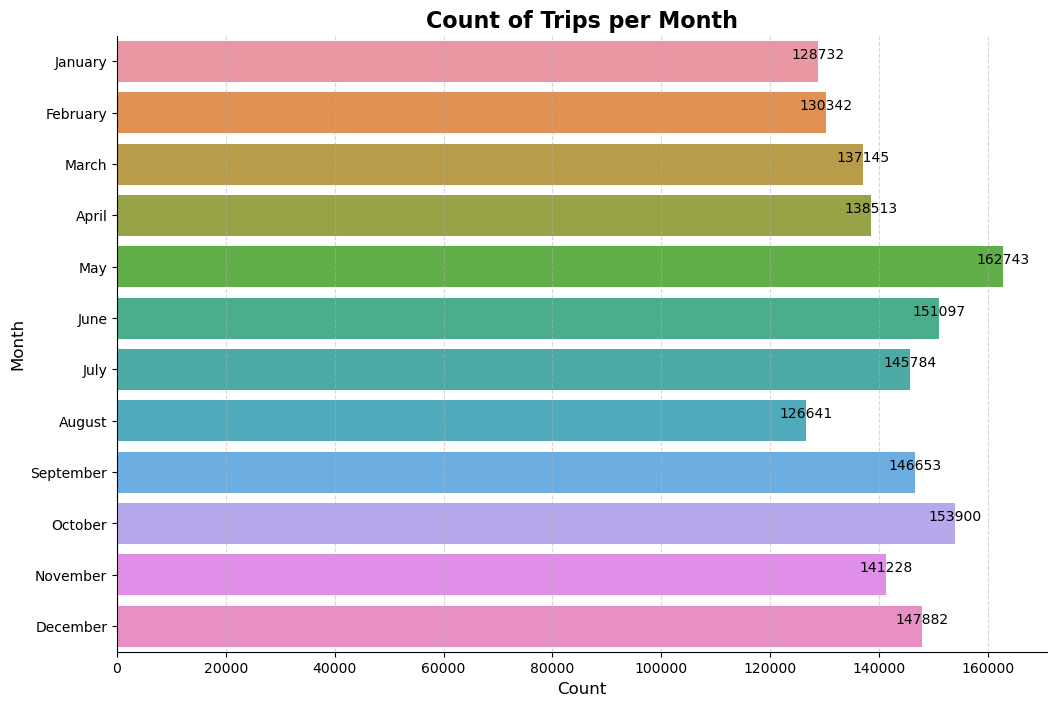

In [19]:
plt.figure(figsize=(12, 8))

ax = sns.countplot(y='MON', data=df_tr)
plt.title('Count of Trips per Month', fontsize=16, fontweight='bold')

plt.xlabel('Count', fontsize=12)
plt.ylabel('Month', fontsize=12)

ax.set_yticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], fontsize=10)

for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), (p.get_width() + 10, p.get_y() + p.get_height() / 2),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


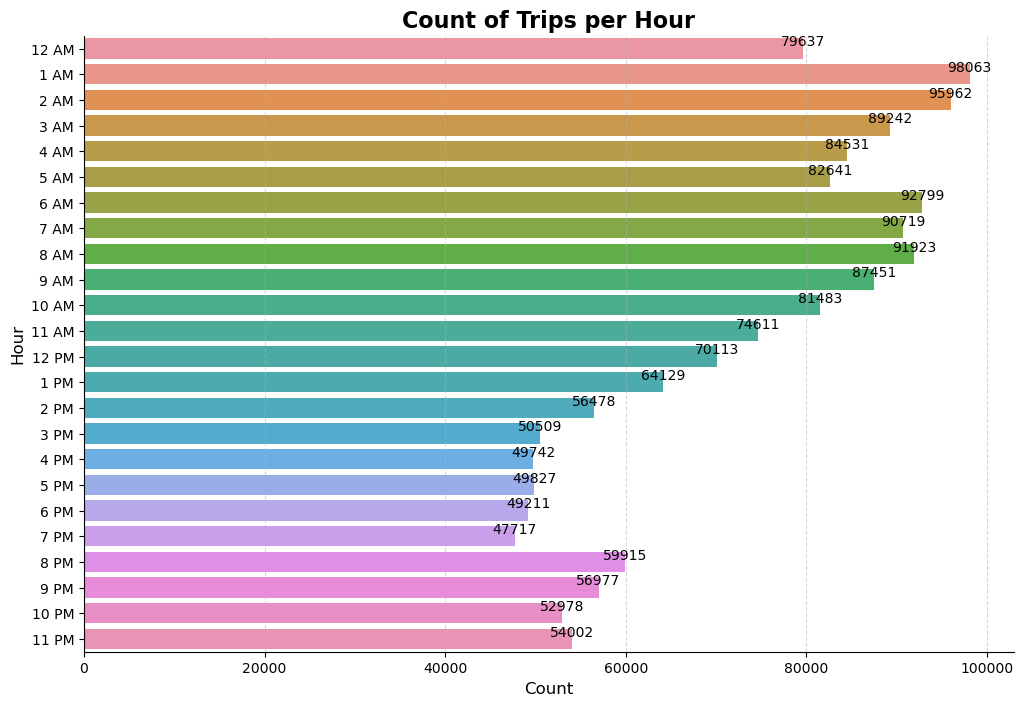

In [20]:
plt.figure(figsize=(12, 8))

ax = sns.countplot(y='HR', data=df_tr)

plt.title('Count of Trips per Hour', fontsize=16, fontweight='bold')

plt.xlabel('Count', fontsize=12)
plt.ylabel('Hour', fontsize=12)

ax.set_yticklabels(['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM',
                    '12 PM', '1 PM', '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM'], fontsize=10)

for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), (p.get_width() + 10, p.get_y() + p.get_height() / 2),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


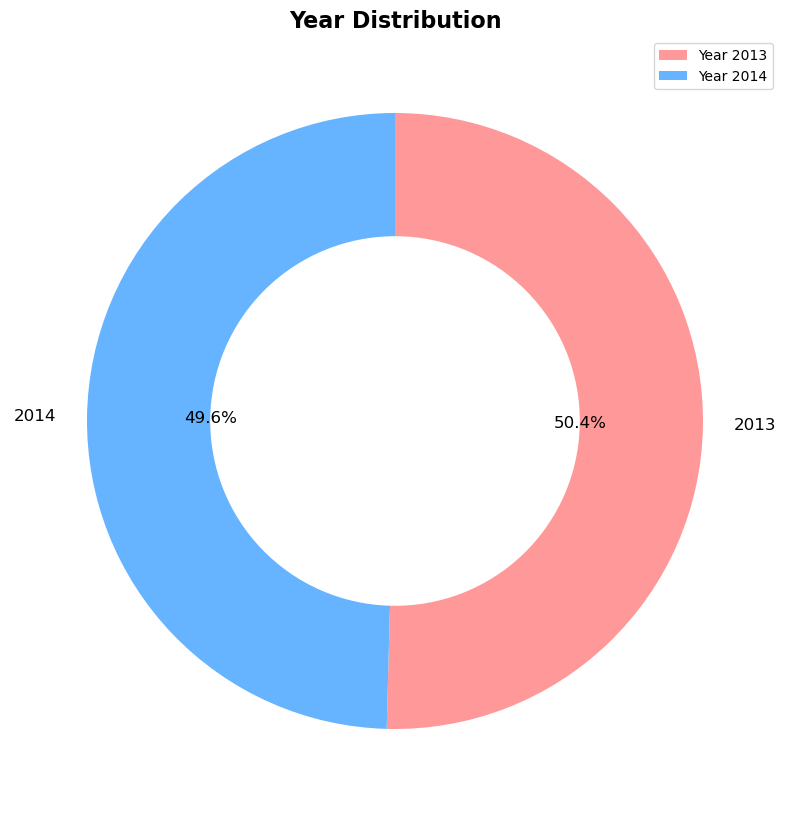

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
year_counts = df_tr['YR'].value_counts()
colors = ['#ff9999', '#66b3ff', '#99ff98', '#ffcc99']

wedges, texts, autotexts = ax.pie(year_counts, labels=year_counts.keys(), autopct='%.1f%%', colors=colors,
                                  startangle=90, counterclock=False, wedgeprops=dict(width=0.4))

plt.setp(texts, size=12)
plt.setp(autotexts, size=12, color='black')
ax.set_title("Year Distribution", fontsize=16, fontweight='bold')

legend_labels = ['Year {}'.format(year) for year in year_counts.keys()]
ax.legend(wedges, legend_labels, loc="best")

ax.set_aspect('equal')
plt.show()


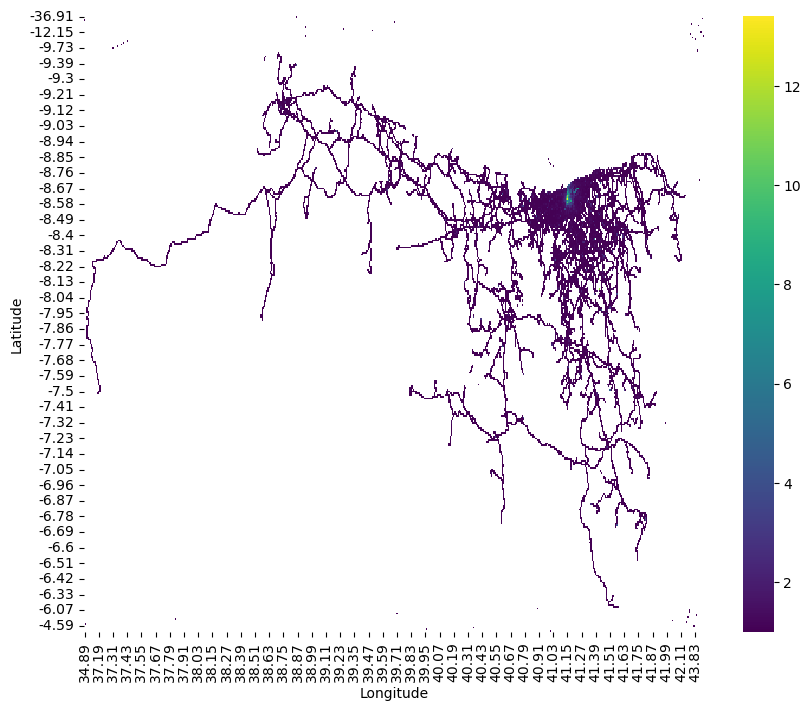

In [24]:
df = pd.read_csv('count_data.csv')

df['Latitude'] = df['Latitude'].round(2)
df['Longitude'] = df['Longitude'].round(2)

pivot_table = df.pivot_table('count', 'Latitude', 'Longitude')
plt.figure(figsize=(10,8))
sns.heatmap(pivot_table, cmap='viridis')


plt.show()

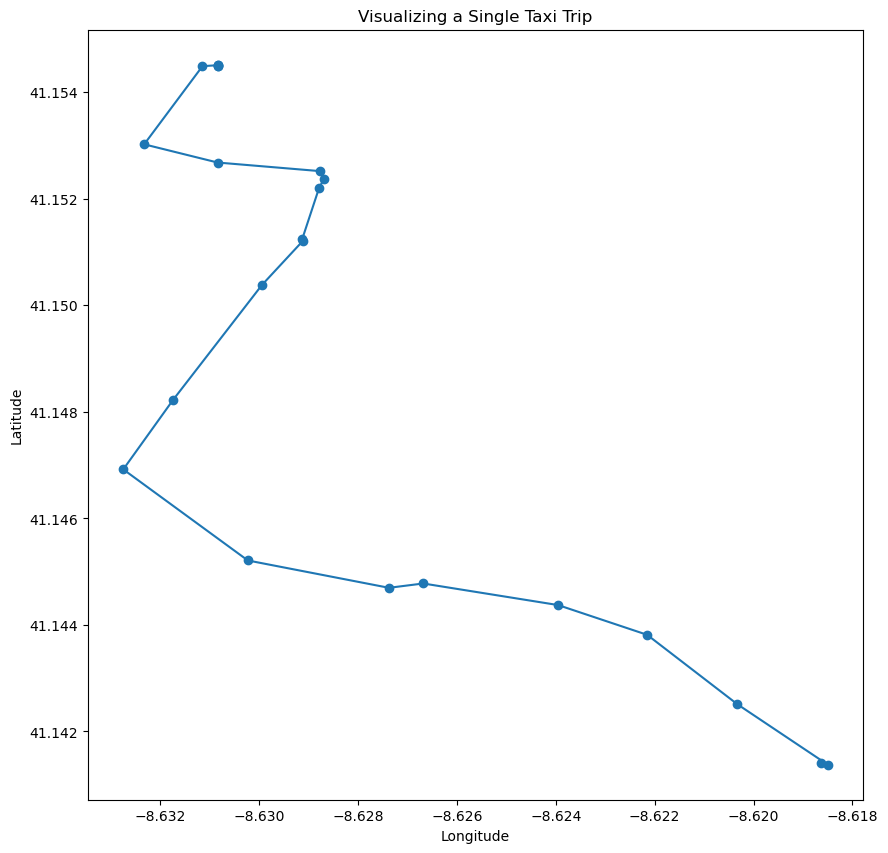

In [1]:
import matplotlib.pyplot as plt

# POLYLINE for a specific trip
polyline = [[-8.618643,41.141412],[-8.618499,41.141376],[-8.620326,41.14251],[-8.622153,41.143815],[-8.623953,41.144373],[-8.62668,41.144778],[-8.627373,41.144697],[-8.630226,41.14521],[-8.632746,41.14692],[-8.631738,41.148225],[-8.629938,41.150385],[-8.62911,41.151213],[-8.629128,41.15124],[-8.628786,41.152203],[-8.628687,41.152374],[-8.628759,41.152518],[-8.630838,41.15268],[-8.632323,41.153022],[-8.631144,41.154489],[-8.630829,41.154507],[-8.630829,41.154516],[-8.630829,41.154498],[-8.630838,41.154489]]

# Unpack the longitude and latitude values
x = [point[0] for point in polyline]
y = [point[1] for point in polyline]

# Create a line plot
plt.figure(figsize=(10,10))
plt.plot(x, y, marker = 'o')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualizing a Single Taxi Trip')

plt.show()


In [2]:
import folium

# POLYLINE for a specific trip
polyline = [[-8.618643,41.141412],[-8.618499,41.141376],[-8.620326,41.14251],[-8.622153,41.143815],[-8.623953,41.144373],[-8.62668,41.144778],[-8.627373,41.144697],[-8.630226,41.14521],[-8.632746,41.14692],[-8.631738,41.148225],[-8.629938,41.150385],[-8.62911,41.151213],[-8.629128,41.15124],[-8.628786,41.152203],[-8.628687,41.152374],[-8.628759,41.152518],[-8.630838,41.15268],[-8.632323,41.153022],[-8.631144,41.154489],[-8.630829,41.154507],[-8.630829,41.154516],[-8.630829,41.154498],[-8.630838,41.154489]]

m = folium.Map(location=[polyline[0][1], polyline[0][0]], zoom_start=14)

for point in polyline:
    folium.Marker(location=[point[1], point[0]]).add_to(m)

# Display the map
m
